# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib notebook
%pylab
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901)
    return corrected_lc

<IPython.core.display.Javascript object>


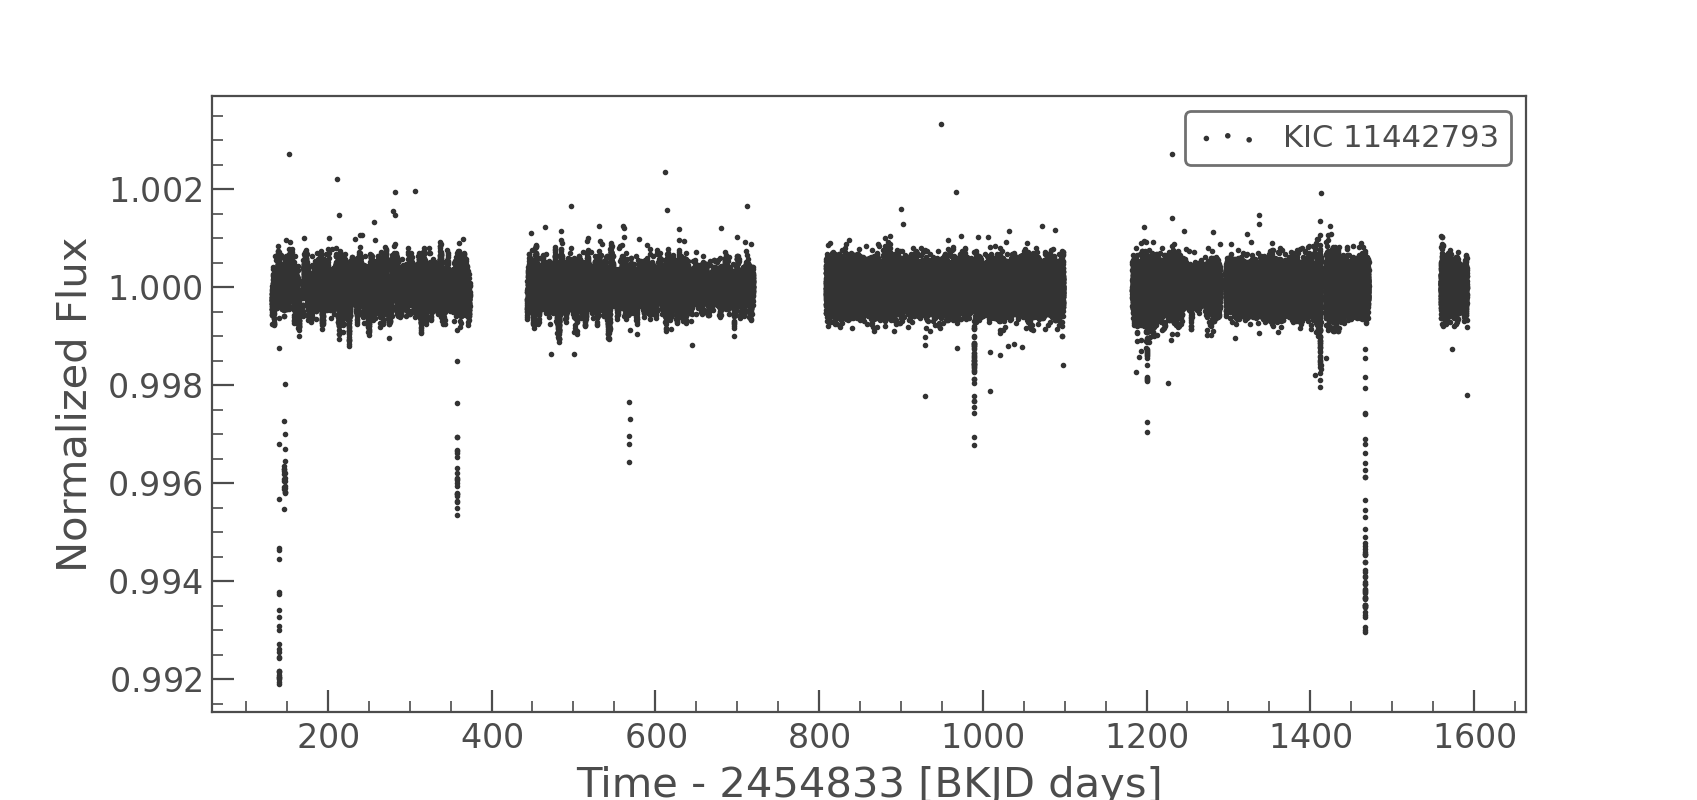

In [4]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


<IPython.core.display.Javascript object>


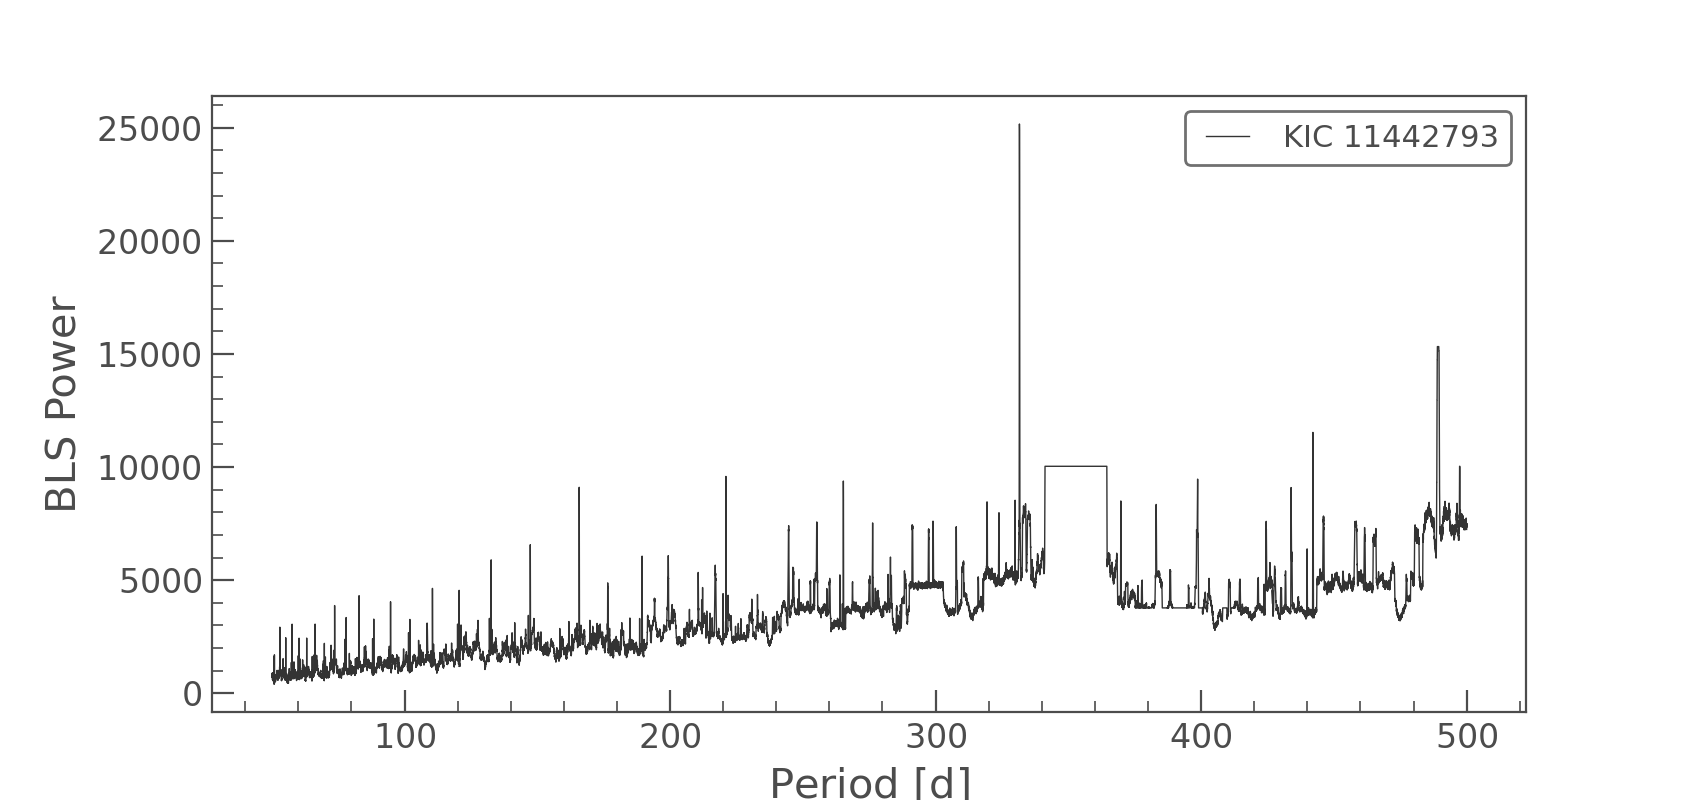

In [5]:
# YOUR CODE HERE
period = np.arange(50,500,.01)
pg = clc.to_periodogram(method='bls', period = period)
pg.plot()
plt.show()

In [6]:
pg.power

<Quantity [ 732.56404257,  763.43512118,  794.28688155, ..., 7318.74802139,
           7503.74945148, 7243.71697871]>

In [7]:
period = np.asarray(pg.period)

In [8]:
mask1 = (period<341) 
mask2 = (period>365)

In [17]:
peaks1 = find_peaks(pg.power[mask1],distance=800)[0]
peaks2 = find_peaks(pg.power[mask2],distance=800)[0]

<IPython.core.display.Javascript object>


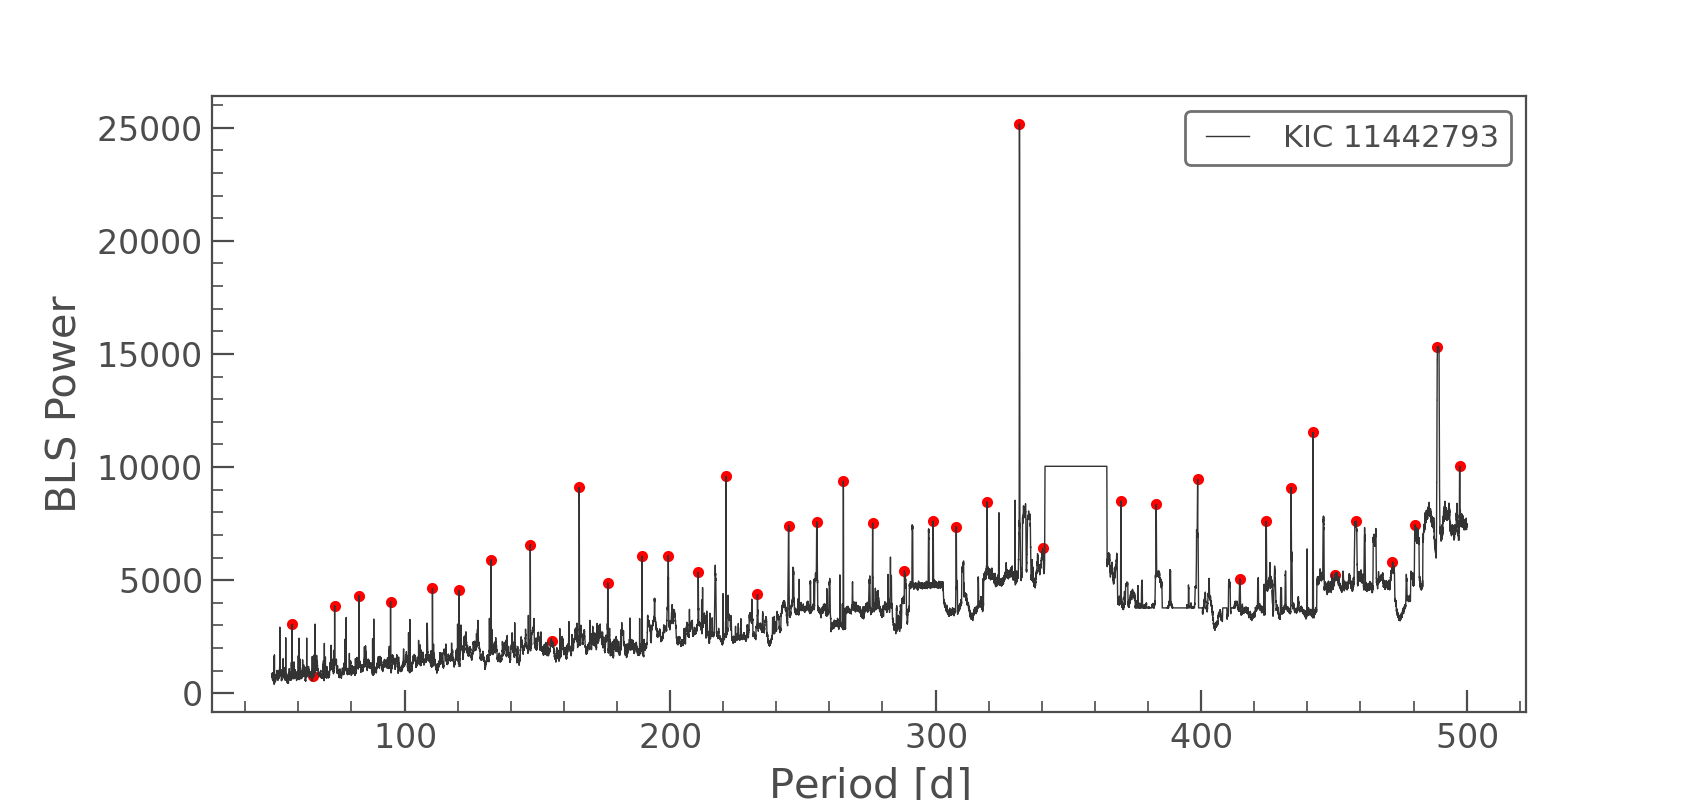

In [20]:
pg.plot()
plt.scatter(pg.period[mask2][peaks2],pg.power[mask2][peaks2],marker='.',c='red')
plt.scatter(pg.period[mask1][peaks1],pg.power[mask1][peaks1],marker='.',c='red')
plt.show()

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [21]:
# YOUR CODE HERE
transit_time = np.asarray(pg.transit_time.value)
power = np.asarray(pg.power)

power_sort = np.argsort(power)
sorted_power = power[power_sort]
sorted_tt = transit_time[power_sort]

In [22]:
print(sorted_tt)

[141.60764779 140.54264779 140.54264779 ... 140.44264779 140.43764779
 140.54264779]


# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [23]:
# YOUR CODE HERE

period = np.asarray(pg.period)

period_sort = np.argsort(period)
sorted_period = period[period_sort]

period_mask = []

rounded_sorted_period = []

for i in sorted_period:
    rounded_sorted_period.append(round(i,6))

for per in sorted_period:
    if ((1/2)*round(per,6) in rounded_sorted_period) or ((1/3)*round(per,6) in rounded_sorted_period):
        period_mask.append(False)
    else:
        period_mask.append(True)



In [24]:
#0 to 100 days
masked_sorted_period = sorted_period[period_mask]
d100_mask = masked_sorted_period<100
masked_sorted_period_d100 = masked_sorted_period[d100_mask]



In [25]:
index_of_periods = []
period_list = period.tolist()
for per in masked_sorted_period_d100:
    index = period_list.index(per)
    index_of_periods.append(index)
max_power_100 = max(power[index_of_periods])
power=power.tolist()
index_100 = power.index(max_power_100)
power=np.asarray(power)
max_period_100 = period[index_100]

In [26]:
#100 to 200 days
greater_d100_mask = masked_sorted_period>100
partial_sort = masked_sorted_period[greater_d100_mask]
less_d200_mask = partial_sort<200
masked_sorted_period_d200 = partial_sort[less_d200_mask]

index_of_periods = []
period_list = period.tolist()
for per in masked_sorted_period_d200:
    index = period_list.index(per)
    index_of_periods.append(index)
max_power_200 = max(power[index_of_periods])
power=power.tolist()
index_200 = power.index(max_power_200)
power=np.asarray(power)
max_period_200 = period[index_200]

In [27]:
#200 to 300 days
greater_d200_mask = masked_sorted_period>200
partial_sort = masked_sorted_period[greater_d200_mask]
less_d300_mask = partial_sort<300
masked_sorted_period_d300 = partial_sort[less_d300_mask]

index_of_periods = []
period_list = period.tolist()
for per in masked_sorted_period_d300:
    index = period_list.index(per)
    index_of_periods.append(index)
max_power_300 = max(power[index_of_periods])
power=power.tolist()
index_300 = power.index(max_power_300)
power=np.asarray(power)
max_period_300 = period[index_300]

In [28]:
#300 to 400 days
greater_d300_mask = masked_sorted_period>300
partial_sort = masked_sorted_period[greater_d300_mask]
less_d400_mask = partial_sort<400
masked_sorted_period_d400 = partial_sort[less_d400_mask]

index_of_periods = []
period_list = period.tolist()
for per in masked_sorted_period_d400:
    index = period_list.index(per)
    index_of_periods.append(index)
max_power_400 = max(power[index_of_periods])
power=power.tolist()
index_400 = power.index(max_power_400)
power=np.asarray(power)
max_period_400 = period[index_400]

# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [29]:
# YOUR CODE HERE
pg = clc.to_periodogram(method='bls', maximum_period = max_period_100-5, minimum_period=max_period_100+5)

max_period_100_fine = pg.period_at_max_power

max_tt_100_fine = pg.transit_time_at_max_power.value

In [30]:
# YOUR CODE HERE
pg = clc.to_periodogram(method='bls', maximum_period = max_period_200-5, minimum_period=max_period_200+5)

max_period_200_fine = pg.period_at_max_power

max_tt_200_fine = pg.transit_time_at_max_power.value

In [31]:
# YOUR CODE HERE
pg = clc.to_periodogram(method='bls', maximum_period = max_period_300-5, minimum_period=max_period_300+5)

max_period_300_fine = pg.period_at_max_power

max_tt_300_fine = pg.transit_time_at_max_power.value

In [32]:
# YOUR CODE HERE
pg = clc.to_periodogram(method='bls', maximum_period = max_period_400-5, minimum_period=max_period_400+5)

max_period_400_fine = pg.period_at_max_power

max_tt_400_fine = pg.transit_time_at_max_power.value

# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

<IPython.core.display.Javascript object>


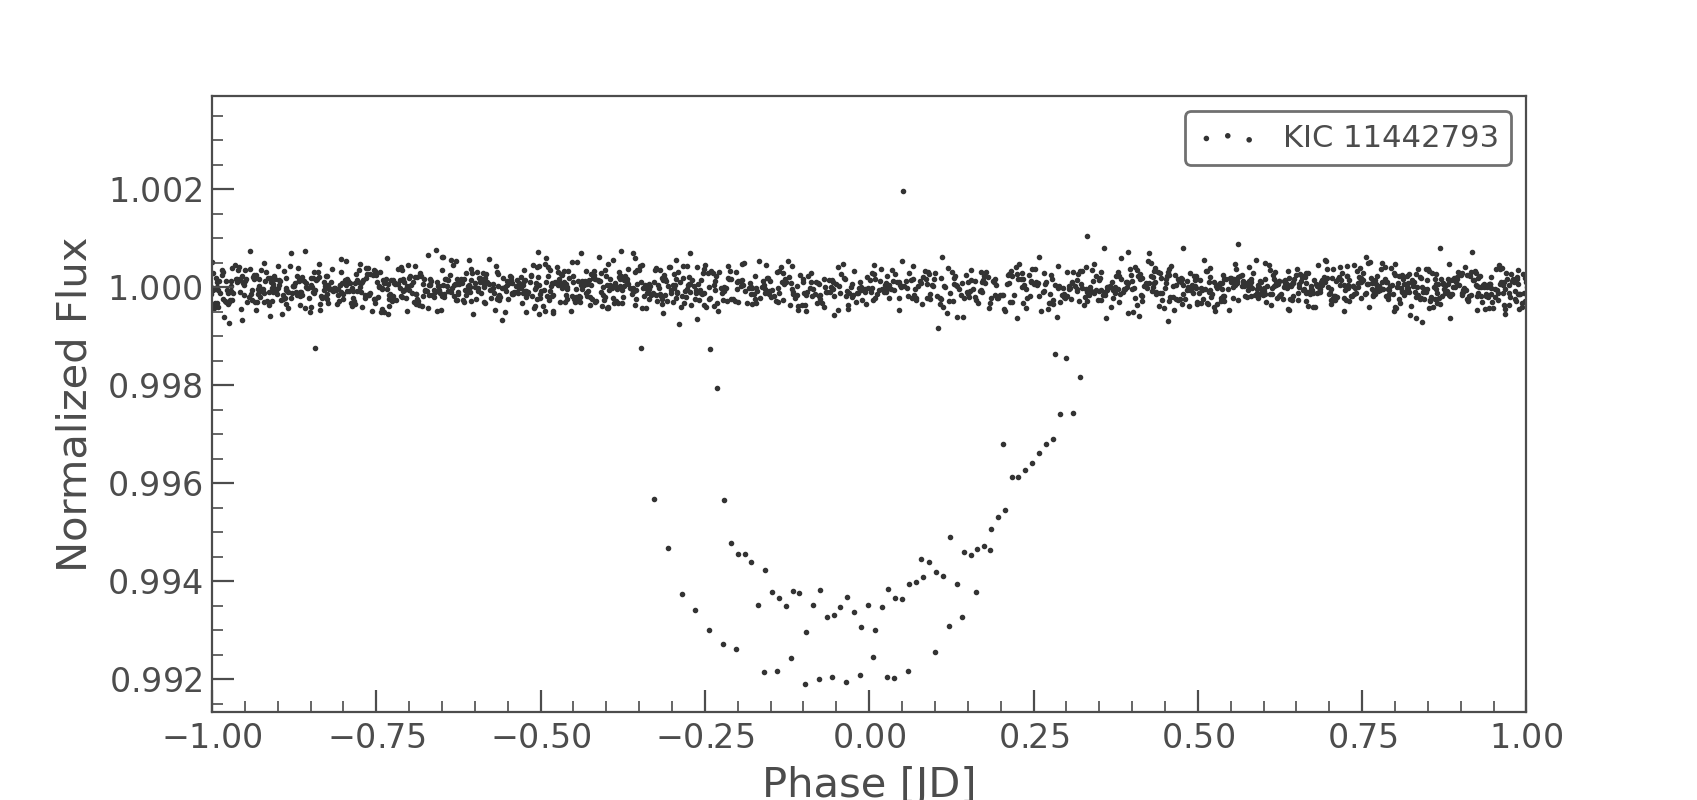

(-1.0, 1.0)

In [45]:
# YOUR CODE HERE

folded = clc.fold(period=max_period_100_fine,epoch_time=max_tt_100_fine)
folded.scatter()
plt.xlim(-1,1)



<IPython.core.display.Javascript object>


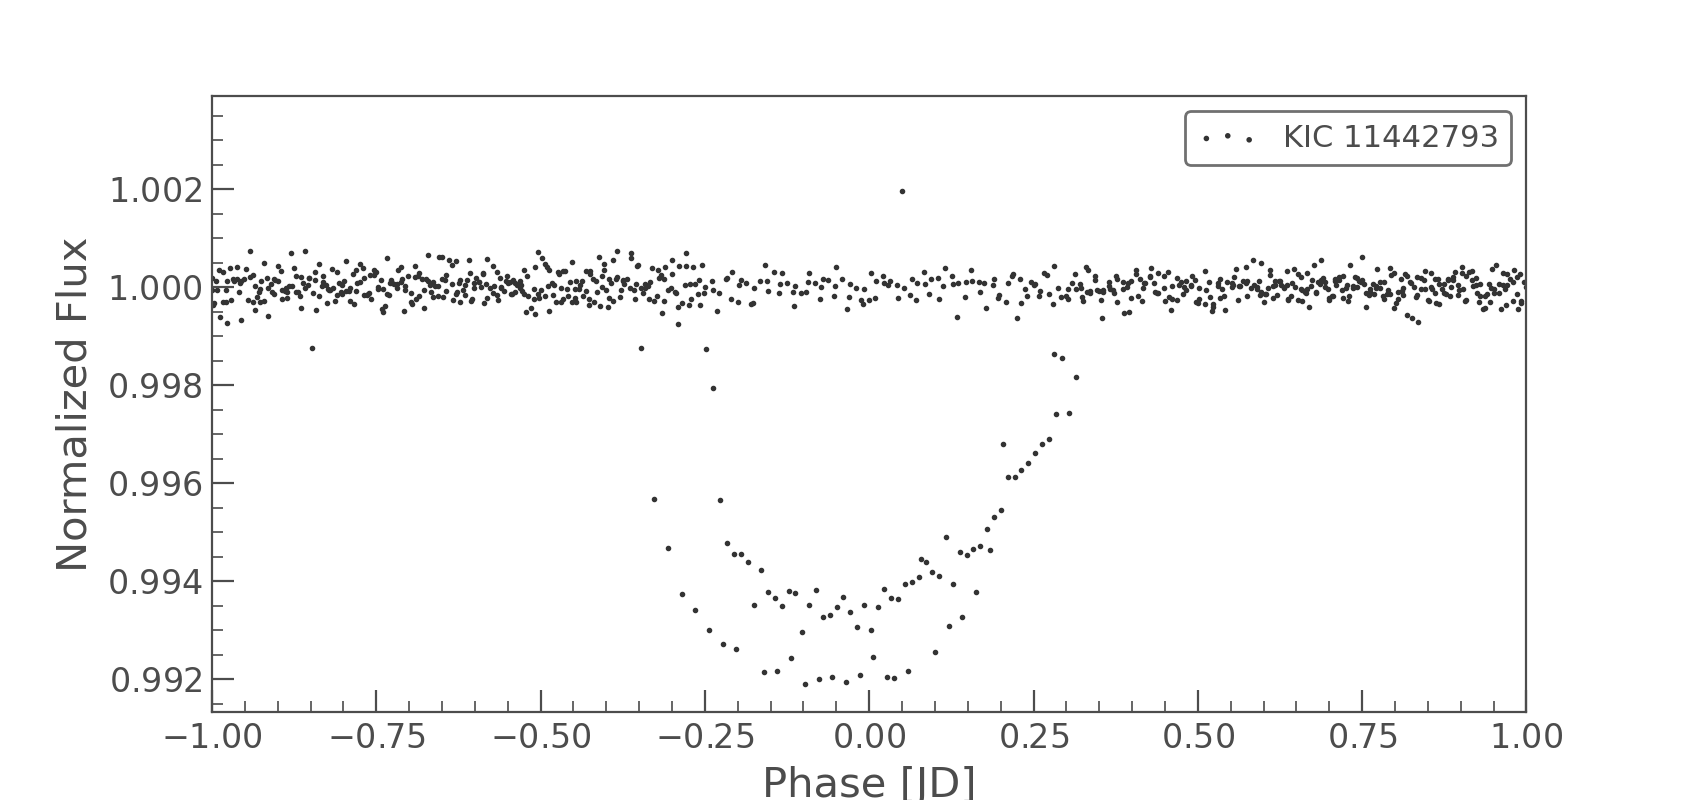

(-1.0, 1.0)

In [37]:
# YOUR CODE HERE

folded = clc.fold(period=max_period_200_fine,epoch_time=max_tt_200_fine)
folded.scatter()
plt.xlim(-1,1)



<IPython.core.display.Javascript object>


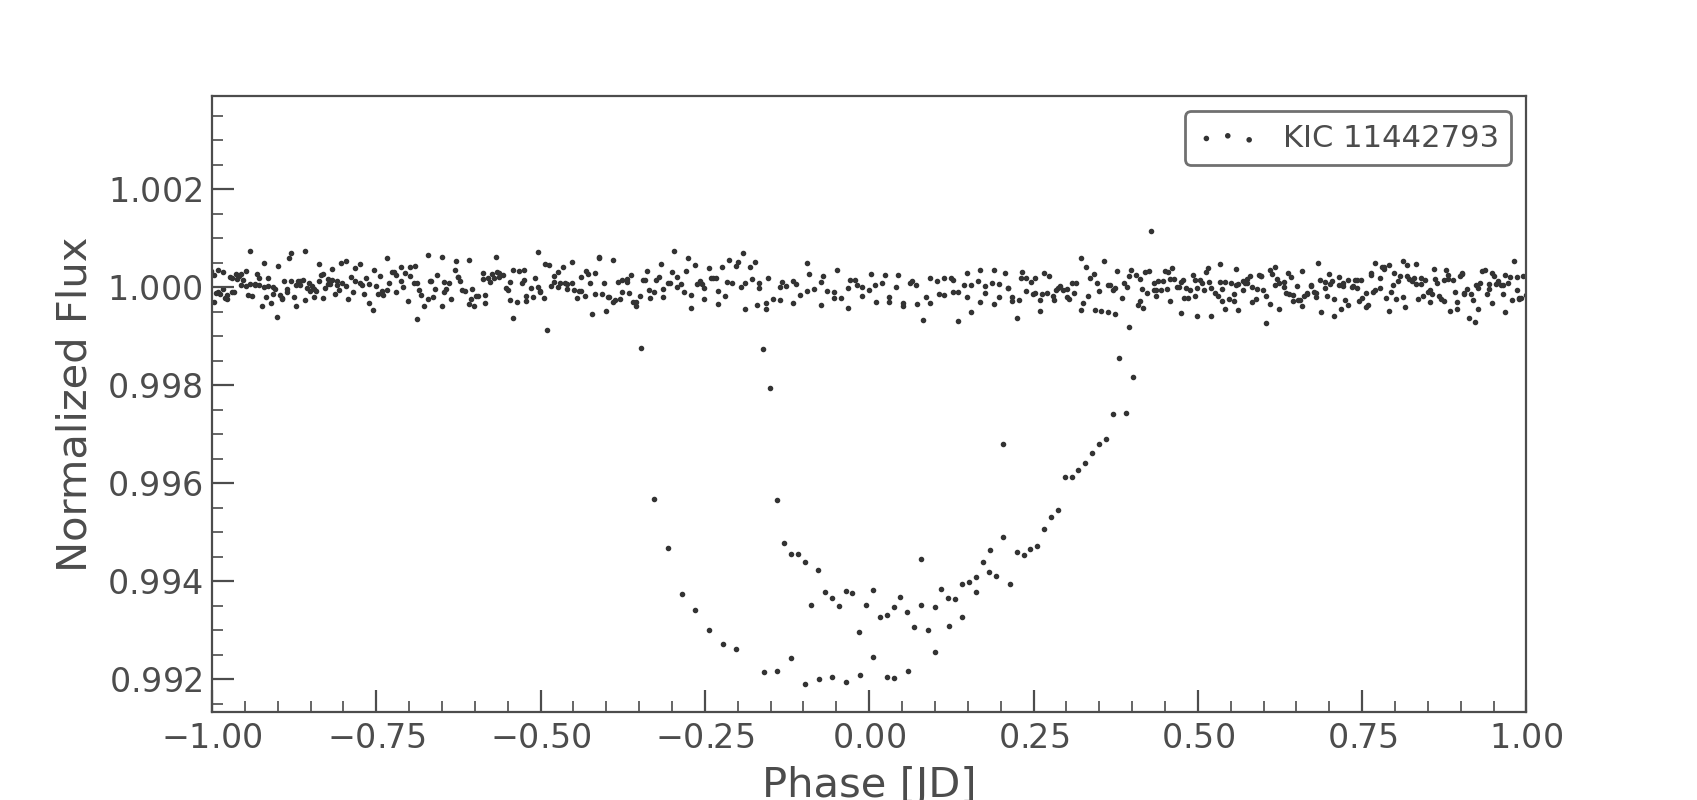

(-1.0, 1.0)

In [39]:
# YOUR CODE HERE

folded = clc.fold(period=max_period_300_fine,epoch_time=max_tt_300_fine)
folded.scatter()
plt.xlim(-1,1)



<IPython.core.display.Javascript object>


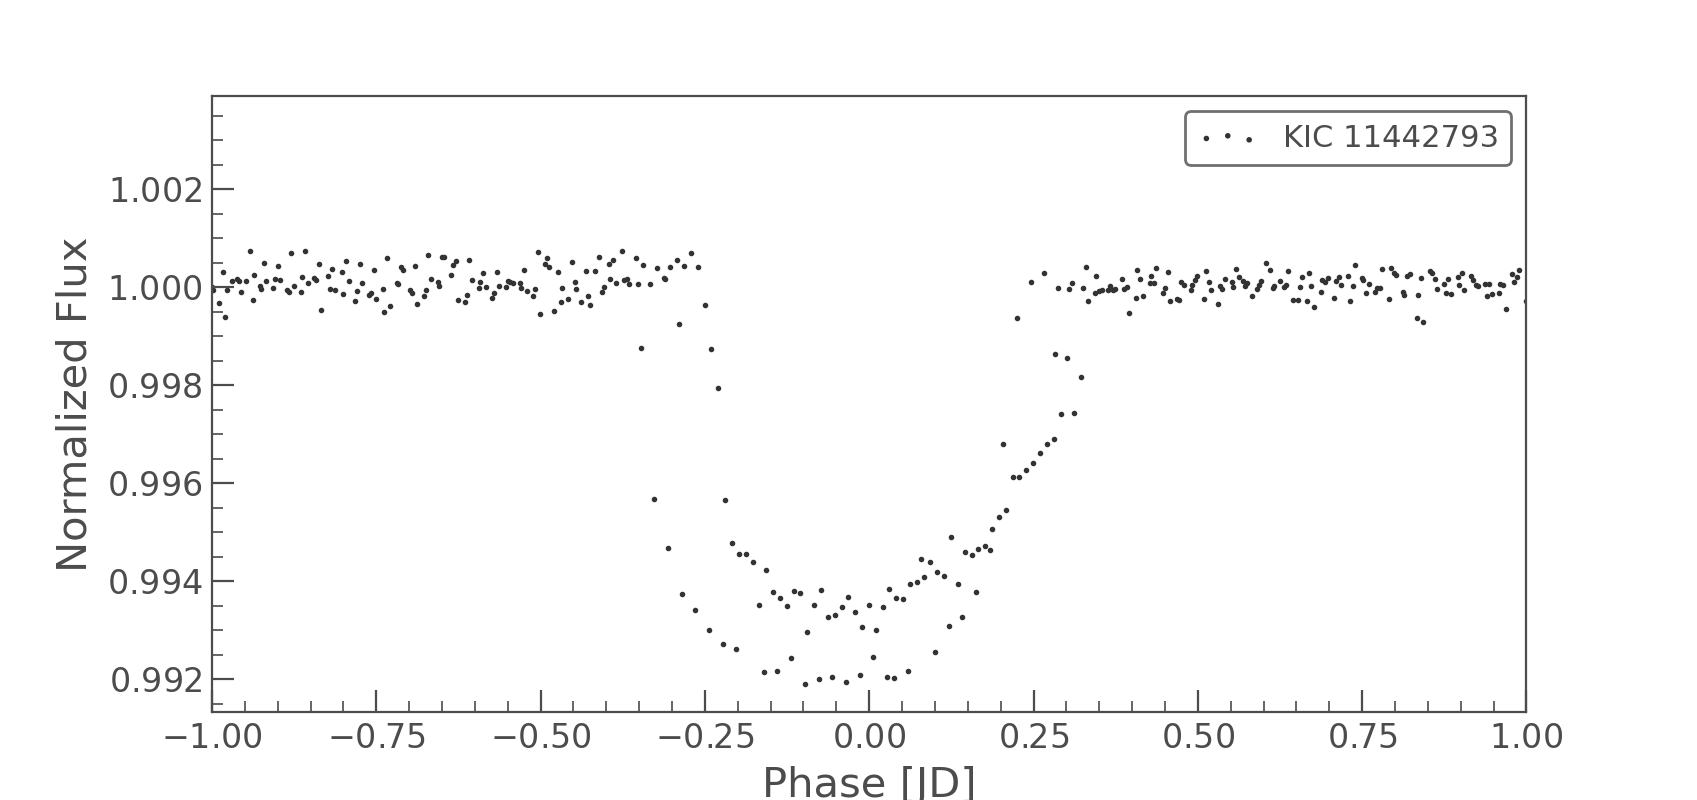

(-1.0, 1.0)

In [41]:
# YOUR CODE HERE

folded = clc.fold(period=max_period_400_fine,epoch_time=max_tt_400_fine)
folded.scatter()
plt.xlim(-1,1)



In [42]:
print(max_period_100_fine,max_period_200_fine,max_period_300_fine,max_period_400_fine)

82.89439944471802 d 165.78955066655286 d 221.0382677310967 d 331.5772027935961 d
